## Facial Attribute Detection Using Convolutional Neural Networks

**Team Members**   
Sike Ogieva and Lee Mabhena  

Dataset is sourced from: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?select=list_attr_celeba.csv   

---


In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

**Pre-Processing Data**

In [2]:
# Read in the facial attributes dataset
dataset = pd.read_csv("archive/list_attr_celeba.csv")

In [3]:
# Print the shape of the dataset, have 202599 rows and 41 columns
dataset.shape

(202599, 41)

In [4]:
# Display the first few rows of the DataFrame to get a quick overview
print("First few rows of the dataset:")
print(dataset.head())

# Get a concise summary of the DataFrame, including the number of non-null values in each column
print("\nDataset summary:")
print(dataset.info())

# Display basic statistical details like percentile, mean, std etc. of a data frame's numeric columns
print("\nBasic statistical details:")
print(dataset.describe())

# Check for missing values in each column
print("\nMissing values in each column:")
print(dataset.isnull().sum())

# Display the names of the columns in the DataFrame
print("\nColumn names:")
print(dataset.columns)

First few rows of the dataset:
     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  We

The dataset contains 40 facial attributes. It maps imageId to the image name in the folder of images. There appear to be no null values and the dataset uses -1 to represent absense of facial attribute and 1 the presence of facial attribute. So we will change the -1 values to 0.

In [5]:
dataset.replace(-1, 0, inplace=True)

We now collect, visualize and normalise the images.

In [6]:
images_data = tf.keras.preprocessing.image_dataset_from_directory(
    "archive/img_align_celeba",
    color_mode='rgb',
    image_size=(64, 64),
    )

Found 202599 files belonging to 1 classes.


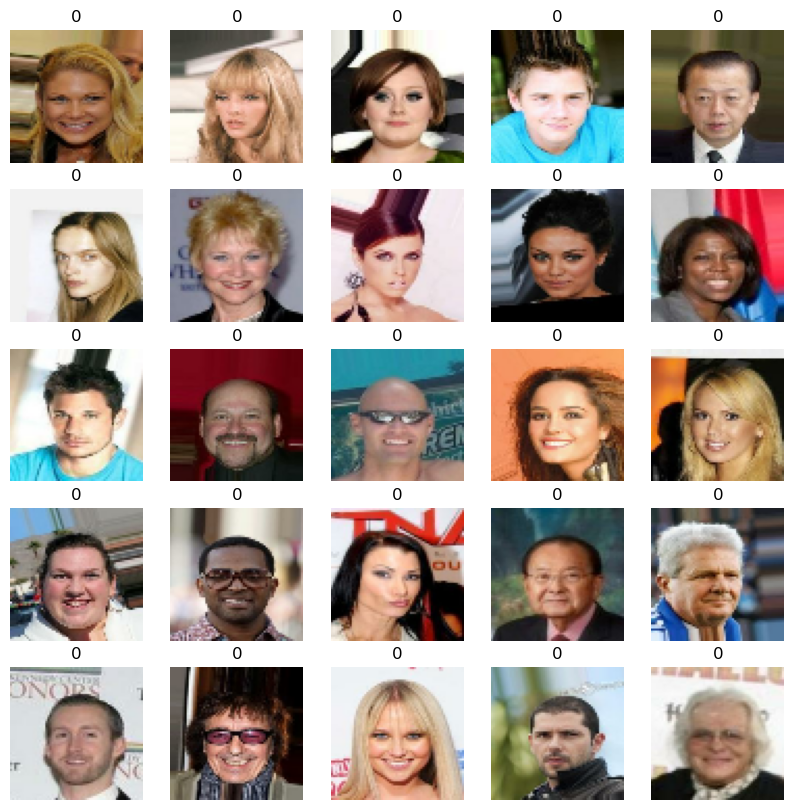

In [7]:
# Visualize the images
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n].numpy().astype("uint8"))
        plt.title(label_batch[n].numpy())
        plt.axis("off")

# Take a single batch of images, and their labels
image_batch, label_batch = next(iter(images_data))

# Show the images
show_batch(image_batch, label_batch)

In [8]:
# Normalize the data to be between 0 and 1
from tensorflow.keras import layers 
normalization_layer = layers.Rescaling(1./255)

normalized_data = images_data.map(lambda x, y: (normalization_layer(x), y))

---

**Splitting the Data**

The authors of the dataset recommend splitting the dataset in the following way: Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing. This is the format we will use in splitting the dataset. The split is 80%, 10%, 10%.

In [ ]:
# Collect and normalize X
paths = []
path_header = 'archive/img_align_celeba/img_align_celeba/'
image_ids_list = dataset['image_id'].tolist()

for image_id in image_ids_list:
    path = path_header + str(image_id)
    paths.append(path)
    
images = np.array([np.array(Image.open(path).resize((64,64))) for path in paths])
images = images.astype('float32') / 255.0  # normalize images to be in the range [0, 1]

In [ ]:
# Collect Y
labels = dataset.drop('image_id', axis=1).to_numpy()

In [ ]:
# Define the indices for splits
train_end, test_start, test_end, valid_start  = 162770, 162771, 182637, 182638

In [ ]:
# Split the images into training, testing and validation
train_data_X = images[:train_end]
test_data_X = images[test_start:test_end]
valid_data_X = images[valid_start:]

# Verify the split
train_data_X.shape, test_data_X.shape, valid_data_X.shape

In [ ]:
# Split the labels into training, testing and validation
train_data_Y = labels[:train_end]
test_data_Y = labels[test_start:test_end]
valid_data_Y = labels[valid_start:]

# Verify the split
train_data_Y.shape, test_data_Y.shape, valid_data_Y.shape

Now, this is a massive dataset so for now, we train, validate and test on only 20% of it.

In [ ]:
# Portion out data for model
train_data_X, leave_X, train_data_Y, leave_Y = train_test_split(train_data_X, train_data_Y, test_size = 0.8, random_state = 42)
valid_data_X, leave_X, valid_data_Y, leave_Y = train_test_split(valid_data_X, valid_data_Y, test_size = 0.8, random_state = 42)
test_data_X, leave_X, test_data_Y, leave_Y   = train_test_split(test_data_X, test_data_Y, test_size = 0.8, random_state = 42)

---

  **Custom Functions**

The in-built evaluation metrics calculate whether for each image, the model has predicted every single one of the 40 attributes correctly and if it misses even one, the whole row is counted as inaccurate-- which would result in unrepresentatively low accuracies.

So here, we write our own evaluation metrics.

In [ ]:
class CustomAccuracy(tf.keras.metrics.Metric):
    
    def __init__(self, name='custom_accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        
        # Initialize the necessary variables for true positives, true negatives, etc.
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions and true values to binary (0 or 1)
        y_pred = tf.round(y_pred)
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)

        # Calculate true positives, true negatives, false positives, and false negatives
        self.true_positives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True)), tf.float32)))
        self.true_negatives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, False)), tf.float32)))
        self.false_positives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True)), tf.float32)))
        self.false_negatives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False)), tf.float32)))

    def result(self):
        # Compute accuracy
        total_correct = self.true_positives + self.true_negatives
        total = self.true_positives + self.true_negatives + self.false_positives + self.false_negatives
        return total_correct / total

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)
        self.true_negatives.assign(0.)
        self.false_positives.assign(0.)
        self.false_negatives.assign(0.)

In [ ]:
class CustomEvaluation():
    
    def __init__(self, predictions, truth_values):
        self.predictions = predictions
        self.truth_values = truth_values
        
        self.nb_images = len(predictions)
        self.nb_features = len(predictions[0])
        self.total_predictions = self.nb_images * self.nb_features
        
        self.true_positives, self.true_negatives, self.false_positives, self.false_negatives = 0, 0, 0, 0        
        self.precomputation()
        
        
    def precomputation(self): 
        for i in range(self.nb_images):
            for j in range(self.nb_features):
                
                truth = self.truth_values[i][j]
                pred  = self.predictions[i][j]
                
                if truth == 0 and pred == 0:
                   self.true_negatives += 1
                elif truth == 1 and pred == 1:
                    self.true_positives += 1
                elif truth == 1 and pred == 0:
                    self.false_negatives += 1
                else:
                    self.false_positives += 1


    def accuracy(self):
        return (self.true_positives + self.true_negatives) / self.total_predictions
        
    def precision(self):
        return self.true_positives / (self.true_positives + self.false_positives)
    
    def recall(self):
        return self.true_positives / (self.true_positives + self.false_negatives)
    
    def f_one(self):
        return 2 * ((self.precision() * self.recall()) / ((self.precision() + self.recall())))

 We use this class to visually and quantitatively evaluate the performance of the model on a specified sample image at the end of each epoch

In [ ]:
class PredictionCallback(keras.callbacks.Callback):
    
    def __init__(self, sample_image, true_labels):
        super(PredictionCallback, self).__init__()
        self.sample_image = sample_image 
        self.true_labels = true_labels  
        
    def on_epoch_end(self, epoch, logs=None):
        # Predict the sample image
        prediction = self.model.predict(np.expand_dims(self.sample_image, axis=0))[0]
        
        # Draw the image
        plt.figure(figsize=(2, 2))
        plt.imshow(self.sample_image)
        plt.title('Sample Image')
        plt.axis('off')
        plt.show()
        
        # Print the prediction results
        print("\nEpoch:", epoch + 1)
        print("Ground truth labels:", self.true_labels)
        print("Predicted labels:", np.round(prediction, 2))
        
sample_image_index = np.random.randint(0, len(train_data_X))  
sample_image = train_data_X[sample_image_index]             
sample_labels = train_data_Y[sample_image_index]

prediction_callback = PredictionCallback(sample_image, sample_labels)

And lastly, we write a function for plotting the changes in validation accuracy and loss as training progressed. As well as the early stopping variable.

In [ ]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['custom_accuracy'])
    plt.plot(network_history.history['val_custom_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

In [ ]:
es = EarlyStopping(patience = 5, min_delta = 0.01, restore_best_weights = True)

---  

**Model Definition and Training**

We start with a simple convolutional neural network.

In [ ]:
# model definition
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(40, activation='sigmoid')) # output layer

# loss function and optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[CustomAccuracy()])

In [ ]:
# training to be visualised
model.fit(
    train_data_X, train_data_Y, 
    validation_data = (valid_data_X, valid_data_Y), 
    batch_size = 128, epochs = 5,
    verbose = 1, callbacks = [prediction_callback]
)

In [ ]:
# actual training
network_history = model.fit(
    train_data_X, train_data_Y, 
    validation_data = (valid_data_X, valid_data_Y), 
    batch_size = 128, epochs = 100000000,
    verbose = 1, callbacks = [es]
)

**Model Evaluation**

In [ ]:
# Look at the training history
plot_history(network_history)

In [ ]:
# Run model on the test data
probabilities = model.predict(test_data_X)
predictions = (probabilities >= 0.5).astype(int)   

In [ ]:
# Print the metrics
ce = CustomEvaluation(predictions, test_data_Y)

print("Accuracy:", ce.accuracy())
print("Precision:", ce.precision())
print("Recall:", ce.recall())
print("F1:", ce.f_one())

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = [[ce.true_negatives, ce.false_positives], [ce.false_negatives, ce.true_positives]]

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes=['No', 'Yes'], title='Confusion Matrix')
plt.show()